<a href="https://colab.research.google.com/github/isismeira/modelo_precificador_imoveis/blob/main/modelo_precificador_de_imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de previsão de Preços de Imóveis na Califórnia: Comparando Regressão Linear, Árvores de Decisão e Florestas Aleatórias

**Objetivo da criação do modelo**: criar um modelo que faça a previsão do preço de um imóvel na região da Califórnia. Esse modelo vai alimentar outro sistema de aprendizado de máquina voltado para a análise e recomendação de investimento em imóveis em alguma área da Califórnia.

**Dataset utilizado**: conjunto de dados dos preços de imóveis da Califórnia armazenado no repositório *StatLib* que tem como base o censo da Califórnia de 1990

**Medida de desempenho escolhida**: Raiz do erro quadrático médio (RMSE)

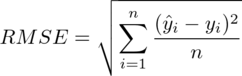

Projeto orientado pelo livro [*Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) do autor *Aurélien Géron*

## Importando bibliotecas

In [198]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix

##Download dos dados

In [199]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [200]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [201]:
fetch_housing_data()

## Análise Exploratória de Dados (EDA)

In [202]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [203]:
dados = load_housing_data()

In [204]:
dados.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Atributos**: longitude, latitude, idade média do imóvel, número de cômodos, número de quartos, população, famílias, renda média,  valor médio do imóvel e proximidade do mar

In [205]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Ao consultar as informações do dataset, existem 20640 instâncias.
Observa-se também que o atributo total_bedrooms tem somente 20433 valores não nulos, mas esses dados serão tratados depois

Também é visível que os valores na coluna ocean_proximity são atributos categóricos. Aqui estão essas categorias:

In [206]:
dados["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


Um resumo dos atributos numéricos com describe():

In [207]:
dados.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Gerando um histograma para cada conjunto numérico

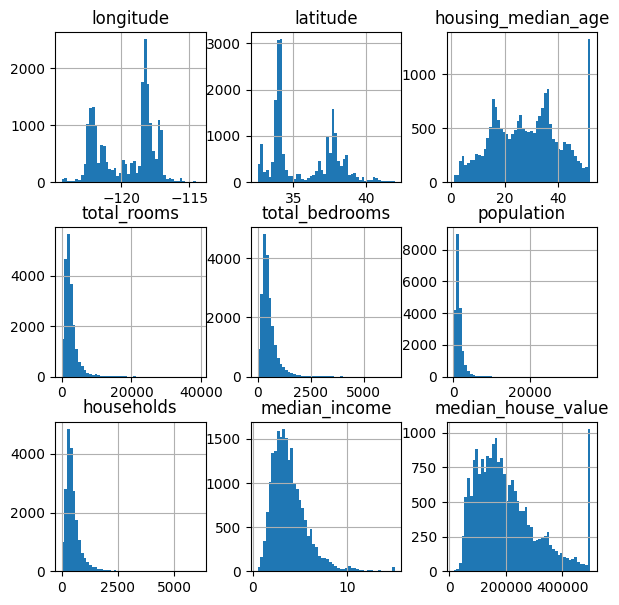

In [208]:
dados.hist(bins=50, figsize=(7,7))
plt.show;

Observações encontradas nesse histograma


*   Tributo da renda média não está expresso em dólares americanos
*   Idade média do imóvel e valor médio de cada móvel foram limitados. É importante saber o que será feito nessa situação, já que o valor médio de cada móvel é o nosso atributo alvo. É possível tomar duas opções nesse caso, ou coletar rótulos adequados para as regiões cujos rótulos foram limitados, ou remover essas regiões do conjunto de treinamento
* Os atributos tem escalas bastante diferentes
* Muitos histogramas tem "*tail-heavy*" ou calda longa. Ou seja, elas se extendem mais pela direita do que pela esquerda



## Criando um conjunto de testes

In [209]:
np.random.seed(42) # para fazer com que o output seja o mesmo a cada execução

In [210]:
# sklearn já tem train_test_split, que faz a mesma função
def separar_conjunto_teste(dados, porcentagem_teste):
  indices_misturados = np.random.permutation(len(dados))
  len_conjunto_teste = int(len(dados) * porcentagem_teste)
  indices_teste = indices_misturados[:len_conjunto_teste]
  indices_treino = indices_misturados[len_conjunto_teste:]
  return dados.iloc[indices_treino], dados.iloc[indices_teste]

In [211]:
conjunto_treino, conjunto_teste = separar_conjunto_teste(dados, 0.2) #20%

In [212]:
len(conjunto_treino), len(conjunto_teste) # 80 / 20

(16512, 4128)

Agora, para ter uma divisão de teste/treinamento estável, fazer o cálculo do hash do identificador de cada instância:

In [213]:
def check_conjunto_de_teste(identificador, porcentagem_teste):
  return crc32(np.int64(identificador)) & 0xffffffff < porcentagem_teste * 2**32

def dividir_conjunto_de_teste_por_id(dados, porcentagem_teste, id_coluna):
  ids = dados[id_coluna]
  in_test_set = ids.apply(lambda id_: check_conjunto_de_teste(id_, porcentagem_teste))
  return dados.loc[~in_test_set], dados.loc[in_test_set]

Como o dataset não tem coluna de identificação, usar o índice da linha como ID

In [214]:
dados_com_id = dados.reset_index()
conjunto_treino_id, conjunto_teste_id = dividir_conjunto_de_teste_por_id(dados_com_id, 0.2, "index")

Para garantir que todos dados sejam anexados ao fim do conjunto de dados e que nenhuma linha seja excluída...

In [215]:
dados_com_id["id"] = dados["longitude"] * 1000 + dados["latitude"]
conjunto_treino_id, conjunto_teste_id = dividir_conjunto_de_teste_por_id(dados_com_id, 0.2, "id")

Supondo que a renda média seja um atributo importante para estimar o preço dos, imóveis, analisar novamente o histograma da renda média

<Axes: >

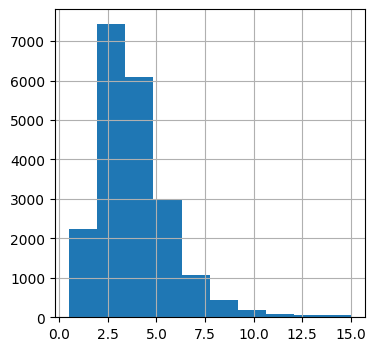

In [216]:
dados["median_income"].hist(figsize=(4,4))

A maioria dos valores médios de renda estão agrupados entre 1.5 e 6.
Vou criar um atributo de categoria  de renda com cinco categorias: a categoria 1 varia de 0 a 1.5, a categoria 2 de 1.5 a 3 e assim por diante

In [217]:
dados["income_cat"] = pd.cut(dados["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In [218]:
dados["income_cat"].value_counts()

,count
income_cat,
3,7236
2,6581
4,3639
5,2362
1,822


Agora, já é possível fazer uma amostragem estratificada com base na categoria de renda

In [219]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dados, dados["income_cat"]):
    strat_train_set = dados.loc[train_index]
    strat_test_set = dados.loc[test_index]

In [220]:
# Proporções de cada categoria no conjunto de testes
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [221]:
# Removendo o atributo income_cat para os dados voltarem ao normal
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Visualizando dados

### Visualizando dados geográficos

<Axes: xlabel='longitude', ylabel='latitude'>

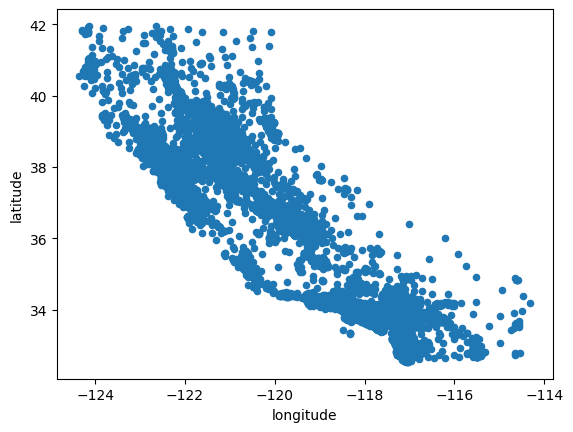

In [222]:
dados.plot(kind="scatter", x="longitude", y="latitude",)

<Axes: xlabel='longitude', ylabel='latitude'>

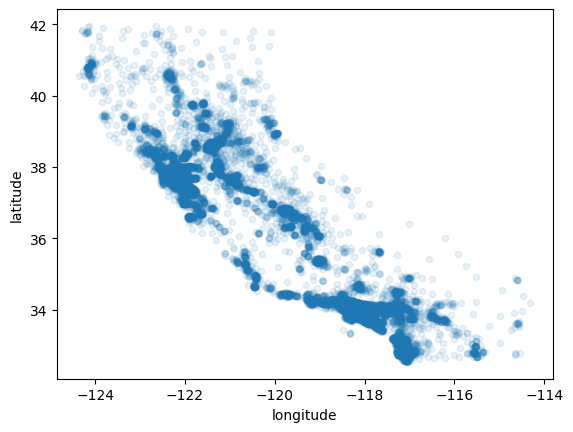

In [223]:
# Visualizando dados
dados.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Áreas de alta densidade: Baía de Los Angeles e San Diego, e Central Valley

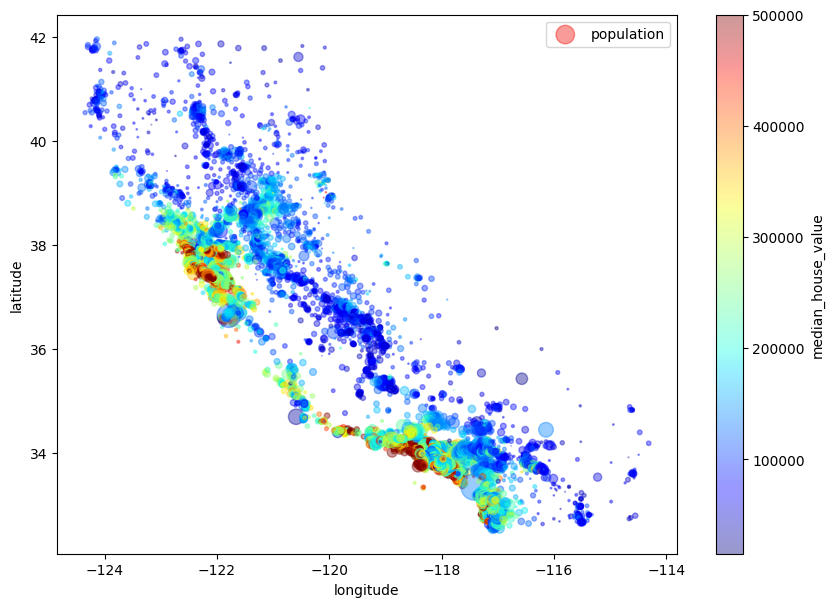

In [224]:
dados.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=dados["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend() # raio do círculo = população / cor = preço

Aqui, percebe-se que os preços dos imóveis estão muito relacionados à proximidade do mar e à densidade populacional. Talvez um algoritmo de clustering funcionaria aqui

### Buscando correlações

In [225]:
corr_matrix = dados.corr(numeric_only=True)

In [226]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


O coeficiente de correlação varia de -1 a 1

Quando está próximo de 1,significa que existe uma forte relação positiva (por exemplo: o valor médio do imóvel tende a subir junto com a renda média)

Quando está próximo de -1, indica uma forte correlação negativa (por exemplo, com a latitude, os preços diminuem quando você vai ao norte)

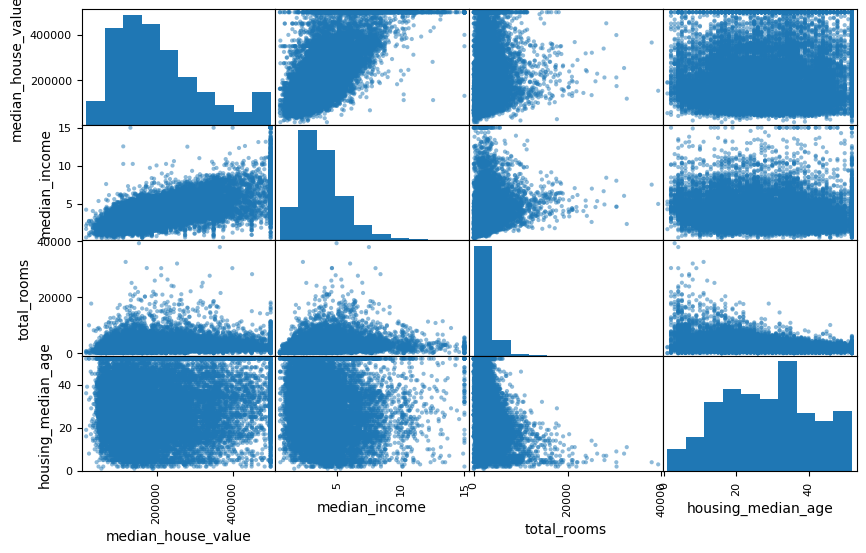

In [227]:
# focando apenas em atributos promissores
atributos = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# plotando cada atributo numérico em relação a qualquer outro atributo numérico
scatter_matrix(dados[atributos], figsize=(10, 6));

<Axes: xlabel='median_income', ylabel='median_house_value'>

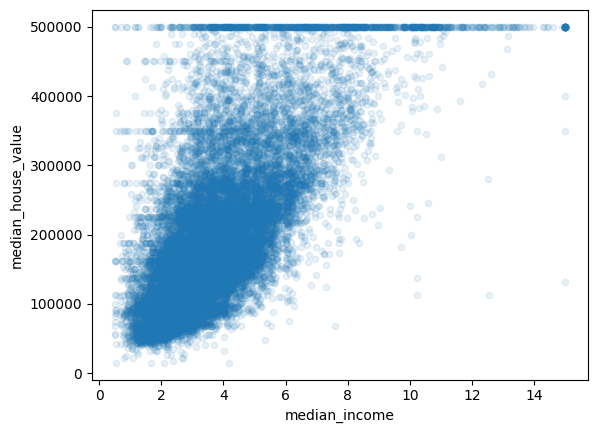

In [228]:
dados.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

Aqui, a correlação entre o preço médio dos imóveis e a renda média é mesmo bem forte, já que existe uma tendência ascendente e os pontos não estão muito dispersos. Porém, há algumas linhas horizontais em certas faixas de preços que seria ideal retirar do dataset, devido a peculiaridade desses dados

### Testando novas combinações

Testando as combinações:


1.   Números de cômodo por família
2.   Numero de quartos por número de cômodos
3.   População por domicílio





In [229]:
dados["comodos_por_familia"] = dados["total_rooms"] / dados["households"]
dados["quartos_por_comodo"] = dados["total_bedrooms"] / dados["total_rooms"]
dados["populacao_por_domicilio"] = dados["population"] / dados["households"]

In [230]:
corr_matrix = dados.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688075
comodos_por_familia,0.151948
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
populacao_por_domicilio,-0.023737
population,-0.024650
longitude,-0.045967


## Tratando os dados

In [231]:
dados = strat_train_set.drop("median_house_value", axis=1) # retira a coluna median_house_value
rotulos_dados = strat_train_set["median_house_value"].copy() # cria uma cópia independente da coluna

### Limpando dados

Como foi visto anteriormente, faltam valores para o atributo "total_bedroom". Nesse caso, vou optar por definir os valores para um valor médio

In [ ]:
dados.dropna(subset=["total_bedrooms"]) # opção 1: remove as linhas NaN
dados["total_bedrooms"].fillna(0, inplace=True) # opção 2: preenche com zeros
media = dados["total_bedrooms"].median() # opção 3: define os valores para um valor médio
dados["total_bedrooms"].fillna(media, inplace=True)

Utilizando a biblioteca SimpleImputer que de encarrega dos valores ausentes (obs. precisei tirar o atributo "ocean_proximity" porque a média só pode ser calculada com valores númericos)

In [233]:
imputer = SimpleImputer(strategy="median")
dados_num = dados.drop("ocean_proximity", axis=1)

In [ ]:
imputer.fit(dados_num) #ajustando a instância aos dados de treinamento

Utilizando a Imputer treinada para transformar o conjunto de treinamento

In [235]:
X = imputer.transform(dados_num)

Colocando de volta ao dataframe...

In [236]:
dados_tr = pd.DataFrame(X, columns=dados_num.columns, index=dados.index)

### Manipulando textos e atributos categóricos

In [237]:
dados_prox_mar = dados[["ocean_proximity"]]
dados_prox_mar.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


Vimos que o atributo "ocean_proximity" é um atributo categórico, mas a maioria dos algoritmos de ML prefere trabalhar com números, então vamos converter essas características de texto em números

In [238]:
ordinal_encoder = OrdinalEncoder()
dados_prox_mar_codificado = ordinal_encoder.fit_transform(dados_prox_mar)
dados_prox_mar_codificado[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

Um problema é que os algoritmos de ML assumem que dois valores próximos são mais semelhantes que dois valores distantes. O que não é o caso da categoria "ocean_proximity".
Para resolver isso, vamos fazer uma *codificação one-hot*, onde apenas um atributo será igual a 1 ("<1H OCEAN") e os outris serão iguais a zero ("INLAND")

In [239]:
codificador_categorias = OneHotEncoder()
dados_prox_mar_1hot = codificador_categorias.fit_transform(dados_prox_mar)
dados_prox_mar_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Customizando transformadores

Aqui, fazemos uma customização de um transformador para criar novos atributos (features) em um DataFrame. Um transformador é uma classe do Scikit-Learn que aplica transformações aos dados (como normalização, codificação ou criação de features) de forma consistente, especialmente útil em pipelines de machine learning.

A classe CombinedAttributesAdder foi cruada para adicionar features novas: rooms_per_household, population_per_household e bedrooms_per_room. Aém de garantir que a transformação seja aplicada igualmente nos dados de treino, teste e validação

In [240]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # sem *args ou **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nada mais a fazer
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(dados.values)

### Transformação de Pipelines

Criando uma pipeline para transformar os dados numéricos de forma automatizada e organizada

In [241]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # substitui os valores NaN pela mediana
        ('attribs_adder', CombinedAttributesAdder()), # adiciona novas features no dataset
        ('std_scaler', StandardScaler()), # padroniza dados para ter média = 0 e desvio padrão = 1
    ])

dados_num_tr = num_pipeline.fit_transform(dados_num) # aplica a pipeline

Pipeline de pré-processamento completo que lida com atributos numéricos e categóricos separadamente

In [242]:
num_atributos = list(dados_num) # lista de colunas numéricas
cat_atributos = ["ocean_proximity"] # colunas categóricas

completo_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_atributos),
        ("cat", OneHotEncoder(), cat_atributos),
    ])

dados_preparados = completo_pipeline.fit_transform(dados)

Agora os dados estão preparados para iniciar o treinamento do modelo

## Escolhendo e treinando um modelo

### Regressão Linear

Treinando agora um primeiro modelo de regressão linear

In [ ]:
from sklearn.linear_model import LinearRegression

reg_lin = LinearRegression()
reg_lin.fit(dados_preparados, rotulos_dados)

In [244]:
alguns_dados = dados.iloc[:5]
alguns_rotulos = rotulos_dados.iloc[:5]
alguns_dados_preparados = completo_pipeline.transform(alguns_dados)
print("Predição:\t", reg_lin.predict(alguns_dados_preparados))
print("Rótulo:\t\t", list(alguns_rotulos))

Predição:	 [ 83829.64916868 306631.28526097 151771.46363803 188612.9401281
 242636.16513523]
Rótulo:		 [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


Funcionou, apesar de que as previsões não sejam exatamente precisas. Calcular agora o RMSE desse modelo:

In [245]:
from sklearn.metrics import mean_squared_error

previsoes_reg_lin = reg_lin.predict(dados_preparados)
mse = mean_squared_error(rotulos_dados, previsoes_reg_lin)
rmse = np.sqrt(mse)
rmse

np.float64(68325.7672026081)

Um erro preditivo de 68.325 dólares não é muito bom para uma média de preços entre 120mil dólares e 265mil dólares. O modelo está subajustado

Por conta do subajuste, talvez seja melhor usar um modelo mais complexo, um DecisionTreeRegressor

### Árvore de Decisão (para regressão)

Um DecisionTreeRegressor é um modelo capaz de identificar relacionamentos não lineares complexos nos dados

In [ ]:
from sklearn.tree import DecisionTreeRegressor

arvore_reg = DecisionTreeRegressor()
arvore_reg.fit(dados_preparados, rotulos_dados)

In [247]:
previsoes_arvore = arvore_reg.predict(dados_preparados)
mse = mean_squared_error(rotulos_dados, previsoes_arvore)
rmse = np.sqrt(mse)
rmse

np.float64(0.0)

Nenhum erro? Claramente o modelo agora sobrejustou os dados. Tentar agora avaliar melhor esse modelo com o método k-fold

### Avaliando o modelo da árvore de decisão com validação cruzada

Aqui, o código divide aleatóriamente o conjunto de treinamento em dez subconjuntos chamados folds, depois treina e avalia o modelo da árvore de decisão 10 vezes, resultando um array contendo 10 classificações de avaliação

In [248]:
from sklearn.model_selection import cross_val_score

pontuacoes_arvore = cross_val_score(arvore_reg, dados_preparados, rotulos_dados,
                             scoring="neg_mean_squared_error", cv=10)
pontuacoes_arvore_rmse = np.sqrt(-pontuacoes_arvore)

In [249]:
def mostrar_pontuacao(pontuacoes):
  print("Pontuações:", pontuacoes)
  print("Média:", pontuacoes.mean())
  print("Desvio padrão:", pontuacoes.std())

mostrar_pontuacao(pontuacoes_arvore_rmse)

Pontuações: [70590.3733468  69257.17428184 67467.05890908 71613.70627126
 67863.2151615  75604.90484351 70486.91047506 74543.5980344
 69591.95485235 71410.27337058]
Média: 70842.91695463982
Desvio padrão: 2486.6166530852815


Um RMSE de 70971 indica que em média, o modelo erra mais ou menos 70.971 dólares. O desvio padrão alto sugere que o modelo tem inconsistências em diferentes folds de avaliação

In [250]:
pontuacoes_reg_lin = cross_val_score(reg_lin, dados_preparados, rotulos_dados,
                             scoring="neg_mean_squared_error", cv=10)
pontuacoes_reg_lin_rmse = np.sqrt(-pontuacoes_reg_lin)
mostrar_pontuacao(pontuacoes_reg_lin_rmse)

Pontuações: [71571.13438866 63769.66653523 68060.69840974 68415.44301226
 66834.89139194 72451.12646637 70144.62578344 68443.00415255
 66104.62581533 70186.97921188]
Média: 68598.2195167404
Desvio padrão: 2481.6795125037406


De fato o modelo está se sobreajustando e acaba sendo pior que o modelo de regressão linear

### Florestas Aleatórias (para regressão)

Agora, tentar o modelo de RandomForestRegressor. As florestas aleatórias funcionam treinando muitas árvores de decisão em subconjuntos aleatórios das características e calculando a média das suas predições

In [ ]:
from sklearn.ensemble import RandomForestRegressor # aprendizado ensemble (sobre outros modelos)

floresta_reg = RandomForestRegressor()
floresta_reg.fit(dados_preparados, rotulos_dados)

In [252]:
previsoes_floresta = floresta_reg.predict(dados_preparados)
mse = mean_squared_error(rotulos_dados, previsoes_floresta)
rmse = np.sqrt(mse)
rmse

np.float64(18696.600301344664)

In [253]:
pontuacoes_floresta = cross_val_score(floresta_reg, dados_preparados, rotulos_dados,
                             scoring="neg_mean_squared_error", cv=10)
pontuacoes_floresta_rmse = np.sqrt(-pontuacoes_floresta)
mostrar_pontuacao(pontuacoes_floresta_rmse)

Pontuações: [51268.98250981 49269.75093165 46748.82771622 51939.23825027
 47210.82833191 51689.70615788 52858.3872808  49485.63013774
 48158.80162247 53545.26027237]
Média: 50217.54132111036
Desvio padrão: 2258.971576155436


Esse modelo é muito melhor comparado aos outros! Mas as pontuações no conjunto de treinamento ainda são muito menores do que no conjunto de validação, o modelo ainda está se sobreajustando

A solução para isso seria simplificar o modelo, regularizá-lo ou obter mais dados de treinamento

Mas por agora, é interessante testar outros modelos para selecionar alguns que sejam mais promissores

## Aperfeiçoando modelos promissores

### Grid search

Uma maneira de aperfeiçoar os modelos promissores é manipulando hiperparâmetros até identificar uma ótima combinação de valores

In [ ]:
from sklearn.model_selection import GridSearchCV

parametros_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

floresta_reg = RandomForestRegressor()

grid_search = GridSearchCV(floresta_reg, parametros_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(dados_preparados, rotulos_dados)

Aqui, obtemos a melhor combinação de parâmetros

In [255]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

Também é possível obter o melhor estimador diretamente

In [ ]:
grid_search.best_estimator_

Os scores de avaliação também estão disponíveis

In [257]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63449.33672595839 {'max_features': 2, 'n_estimators': 3}
55307.7010169025 {'max_features': 2, 'n_estimators': 10}
52800.57473108314 {'max_features': 2, 'n_estimators': 30}
60048.05833571789 {'max_features': 4, 'n_estimators': 3}
53367.29112084581 {'max_features': 4, 'n_estimators': 10}
50334.383123861204 {'max_features': 4, 'n_estimators': 30}
59036.113109203405 {'max_features': 6, 'n_estimators': 3}
52091.345171577916 {'max_features': 6, 'n_estimators': 10}
49993.82305498454 {'max_features': 6, 'n_estimators': 30}
58922.83085834954 {'max_features': 8, 'n_estimators': 3}
52574.24325548147 {'max_features': 8, 'n_estimators': 10}
50054.17563232679 {'max_features': 8, 'n_estimators': 30}
62583.07573561025 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54004.89325444874 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59602.29862993501 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52655.25166813717 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

De fato, a melhor solução é definir o hiperparâmetro max_features em 8 eo hiperparâmetro n_estimators em 30. A pontuação RMSE é de 49867.95 (um pouco melhor que o resultado obtido anteriormente)

### Analisando os melhores modelos

É interessante saber sobre a importância relativa de cada atributo para realizar as predições, talvez isso dê pistas importantes sobre onde está o problema no modelo

In [258]:
importancia_atributos = grid_search.best_estimator_.feature_importances_
importancia_atributos

array([7.41816342e-02, 6.30568270e-02, 4.23197436e-02, 2.01585996e-02,
       1.60528305e-02, 1.91082422e-02, 1.68642699e-02, 3.11414725e-01,
       5.99134894e-02, 1.09762916e-01, 7.89168534e-02, 8.07153375e-03,
       1.73863856e-01, 7.26815445e-05, 2.65724789e-03, 3.58454923e-03])

In [259]:
atributos_extra = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = completo_pipeline.named_transformers_["cat"]
cat_atributos = list(cat_encoder.categories_[0])
atributos = num_atributos + atributos_extra + cat_atributos
sorted(zip(importancia_atributos, atributos), reverse=True)

[(np.float64(0.3114147254172251), 'median_income'),
 (np.float64(0.17386385607205518), 'INLAND'),
 (np.float64(0.10976291611368974), 'pop_per_hhold'),
 (np.float64(0.07891685343385874), 'bedrooms_per_room'),
 (np.float64(0.07418163421826783), 'longitude'),
 (np.float64(0.06305682700628841), 'latitude'),
 (np.float64(0.05991348942172932), 'rooms_per_hhold'),
 (np.float64(0.04231974363033925), 'housing_median_age'),
 (np.float64(0.020158599611196495), 'total_rooms'),
 (np.float64(0.01910824222531259), 'population'),
 (np.float64(0.01686426994640795), 'households'),
 (np.float64(0.016052830491389867), 'total_bedrooms'),
 (np.float64(0.00807153374713754), '<1H OCEAN'),
 (np.float64(0.003584549227807698), 'NEAR OCEAN'),
 (np.float64(0.002657247892754564), 'NEAR BAY'),
 (np.float64(7.268154453970478e-05), 'ISLAND')]

Aqui, é interessante descartar algumas características menos úteis que outras

### Avaliar sistema no conjunto de testes

Depois dos ajustes no modelo, é hora de avaliar o modelo final no conjunto de testes

In [260]:
modelo_final = grid_search.best_estimator_

x_teste = strat_test_set.drop("median_house_value", axis=1)
y_teste = strat_test_set["median_house_value"].copy()

x_teste_preparado = completo_pipeline.transform(x_teste)
final_previsoes = modelo_final.predict(x_teste_preparado)

final_mse = mean_squared_error(y_teste, final_previsoes)
final_rmse = np.sqrt(final_mse)

In [261]:
final_rmse

np.float64(48530.192280824536)

Para ter uma ideia da precisão da estimativa, é possível calcular um intervalo de confiança de 95% para o erro de generalização

In [262]:
from scipy import stats

confianca = 0.95
erro_padrao = (final_previsoes - y_teste) ** 2
np.sqrt(stats.t.interval(confianca, len(erro_padrao) - 1,
                         loc=erro_padrao.mean(),
                         scale=stats.sem(erro_padrao)))

array([46529.29451679, 50451.79756359])